## Model training
In this notebook we'll first define a baseline model and then train a couple of ML models to try to better that performance.

The dataset is quite small and the features are few, so I'm going to keep it simple in terms of algotrithms. We'll see how a logistic regression model and a random forest model compare against each other and the baseline model-

In [18]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

sns.set()
default_color='steelblue'

features = [
    'is_white',
    'rating',
    'rating_diff',
    'is_3min',
    'did_win_last',
    'avg_points_last_5'
]

data_path = '/home/jovyan/work/data/'
train_data_filename = 'train_data.csv'
test_data_filename = 'test_data.csv'

model_output_path = '/home/jovyan/work/model/'
model_filename = 'chess_prediction_model.sav'

### Define functions

In [2]:
def avg_points_prev_rows(df, num_games):
    """Return the average of column 'won_points' over a set number of rows.
    Need data to be sorted ascending by time to return a chonological history
    """
    avg_points = (
        df.rolling(num_games, min_periods=1, closed='both')
        ['won_points'].sum()
        .sub(df['won_points'])  # Don't inlude this record's result
        .div(num_games))
    return avg_points


def get_X_and_y(df, features):
    """Return a feature dataframe (X) and a target dataframe (y) from downloaded data
    """
    # Sort data by time to get chronological features right
    df['end_ts'] = pd.to_datetime(df['end_date_local'].astype('str') + " " + \
                                  df['end_time_local'].astype('str'))
    df = df.sort_values('end_ts', ascending=True)
    
    df['rating_diff'] = df['rating'].sub(df['opp_rating'])
    df['is_3min'] = df['time_control'].str.startswith('180').astype('int')
    df['did_win_last'] = (avg_points_prev_rows(df, 1) == 1).astype('int')
    df['avg_points_last_5'] = avg_points_prev_rows(df, 5)
    X = df[features]
    y = df['is_loss']
    return (X, y) 


def print_prob_dist(clf, X):
    """ Plot KDE curves for predicted probabilities of actual 0's and 1's
    """
    probs = clf.predict_proba(X_train)[:, 1]
    plot_df = pd.DataFrame({'y': y_train,'p': probs})

    sns.kdeplot(data=plot_df[plot_df['y'] ==  0], x='p', common_norm=False, label='Is Not Loss')
    sns.kdeplot(data=plot_df[plot_df['y'] ==  1], x='p', common_norm=False, label='Is Loss')
    plt.title(f"Prediction probabilities by actual label\n {clf.estimator.named_steps['clf']}")
    plt.xlabel("Probability of losing game")
    plt.legend()
    plt.xlim(0, 1)
    plt.show()

### Load data

In [3]:
# Read training data into a pandas DataFrame : df
df_train = pd.read_csv(data_path + train_data_filename)
df_test = pd.read_csv(data_path + test_data_filename)

X_train, y_train = get_X_and_y(df_train, features)
X_test, y_test = get_X_and_y(df_test, features)

In [4]:
# Display sample rows from feature dataframe X_train
display(X_train.head(3))

,is_white,rating,rating_diff,is_3min,did_win_last,avg_points_last_5
1567,1,1030,-188,0,0,0.0
1932,1,1227,86,0,0,0.0
5,0,1369,47,0,1,0.2


### Target balance  

In [5]:
print("Share of losses in the training data:",
      np.round(y_train.mean(), 2))

Share of losses in the training data: 0.48


So, 52% accuracy is the best we could do without knowing or learning anything at all and just always predicting 0.

### Baseline model  
In this first step we'll create a simple model to benchmark later models against. Let's use the seemingly strongest feature that measures the difference of ratings (rating_diff). We
ll always predict loss when an underdog ratingwise, and never predict a loss else.

In [6]:
baseline_preds = np.where(X_train['rating_diff'] < 0, 1, 0)
baseline_accuracy = accuracy_score(baseline_preds, y_train)

print("Baseline accuracy:", np.round(baseline_accuracy, 2))

Baseline accuracy: 0.68


### Logistic regression  

Let's first train a logistic regression classifier, and use sklearn's GridSearchCV to tune the parameters.

In [7]:
param_grid = {'clf__penalty': ['l1', 'l2'],
              'clf__C' : np.logspace(-4, 4, 50)}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(solver='liblinear',
                               class_weight='balanced',
                               max_iter=1_000,
                               random_state=1))])

lr_clf = GridSearchCV(pipe,
                      param_grid=param_grid,
                      cv=5,
                      return_train_score=True,
                      verbose=True,
                      n_jobs=-1,
                      scoring='accuracy')

# Fit on data
lr_clf = lr_clf.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [8]:
# Print the best model parameters and best score
print("Chosen parameters:", lr_clf.best_params_)
print("Best mean cross validation score", 
      np.round(lr_clf.best_score_, 2))

Chosen parameters: {'clf__C': 0.00021209508879201905, 'clf__penalty': 'l2'}
Best mean cross validation score 0.7


The cross validated accuracy is better than the beseline model's, but only slightly so.

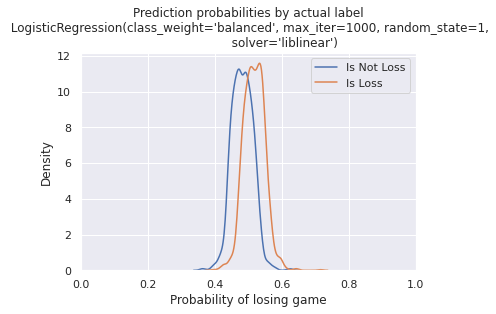

In [9]:
# Plot kernel densities for predicted probabilities by actual outcome
print_prob_dist(lr_clf, X_train)

The plot above graphically shows the substantial overlap between the distributions meaning that when using a cutoff value of 0.5 there will be quite a lot of misclassification for both labels.

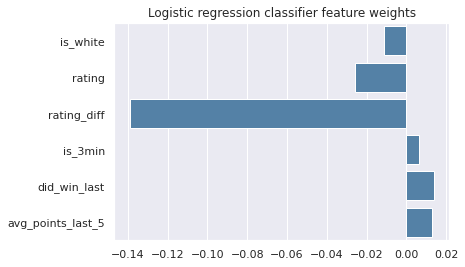

In [10]:
sns.barplot(x=lr_clf.best_estimator_.named_steps['clf'].coef_[0],
            y=lr_clf.best_estimator_.feature_names_in_,
            color=default_color)
plt.title('Logistic regression classifier feature weights')
plt.show()

The traning pipeline standardized the features so the coefficients can be interpreted as a form of feature impact score in the fitted model. The feature rating_diff stands out. The lower the rating_diff goes (and it's negative when the opponent has the higher rating) the higher the probability of losing.

## Random Forest  

Next we'll see if a random forest classifier can beat logistic regression for this task. The non-linearity of the algorithm could potentially pick up different patters both between features and target, and between different features.

In [11]:
param_grid = { 
    'clf__n_estimators': [500, 1_000, 1_500],
    'clf__max_features': [2, 'auto', 'sqrt', 'log2'],
    'clf__max_depth' : [2, 3, 4, 5],
    'clf__criterion' : ['gini', 'entropy']
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(class_weight='balanced',
                                   random_state=1))])

rf_clf = GridSearchCV(pipe,
                      param_grid=param_grid,
                      cv=5,
                      verbose=True,
                      n_jobs=-1,
                      scoring='accuracy')

# Fit on data
rf_clf = rf_clf.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [12]:
# Print the best model parameters and best score
print("Chosen parameters:", rf_clf.best_params_)
print("Best mean cross validation score", 
      np.round(rf_clf.best_score_, 2))

Chosen parameters: {'clf__criterion': 'gini', 'clf__max_depth': 4, 'clf__max_features': 2, 'clf__n_estimators': 500}
Best mean cross validation score 0.69


The cross validatet accurracy is a little worse for the random forest model than the logistic regression model, but it's very even.

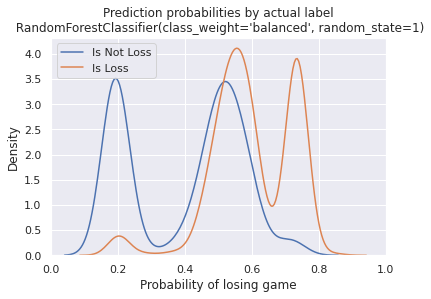

In [30]:
# Visualise the probability 
print_prob_dist(rf_clf, X_train)

The random forest model can classify a good chunk of the records correctly as clear wins and losses. But there's also many records in the middle where the model doesn't do that great in telling the classes apart.

### Conclusion  

Neither model really improves much on the baseline model which only predicts from who's got the higher rating. Whether the extra couple of percentages of correct classifications would warrant the added complexity of using a ML-model rather than a 'business rule' would be up for debate depending on the use case.

The logistic regression model performed slightly better than the random forrest model, so I'll go with that one. Although the improvment compared to the baseline is underwhelming remeber that we kep everythin as simple as possible in this first iteration. Another round of feature engineering could well improve the results. The general conclusion will likely still hold though - that there is much noise in the signal and that it's unlikely one could get near perfect accuracy only based on the game history.

Now it's time to see how the baseline model and logistic regression classifier performs on the test data and take a look at the confusion matrix to get a feel for how the trained model predicting.

##### Performance on test data

In [14]:
baseline_test_preds = np.where(X_test['rating_diff'] < 0, 1, 0)
baseline_test_accuracy = accuracy_score(baseline_test_preds, y_test)
print("Baseline accuracy on test data:",
      np.round(baseline_test_accuracy, 2))
print("Logistic regression model accuracy on test data:",
      np.round(lr_clf.score(X_test, y_test), 2))

Baseline accuracy on test data: 0.66
Logistic regression model accuracy on test data: 0.68


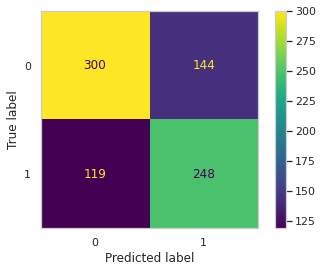

In [15]:
# Plot confusion matrix
sns.set_style("whitegrid", {'axes.grid' : False})
preds = lr_clf.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=lr_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=lr_clf.classes_)
disp.plot()
plt.show()

#### Save model


In [16]:
pickle.dump(lr_clf, open(model_output_path + model_filename, 'wb'))